# WellCo churn reduction: prioritize outreach

**Deliverable:** a CSV with the top `n` members for outreach, including `member_id`, a prioritization score, and rank.


This notebook:
- builds member-level features (web/app/claims)
- validates signal with a churn-risk model (CV on train; final evaluation on the provided test set)
- models outreach impact via uplift (treatment effect) and produces a ranked outreach list
- chooses `n` using training-only (out-of-fold) uplift to avoid test leakage


In [1]:
from __future__ import annotations

import re
import warnings
from dataclasses import dataclass
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    classification_report,
    f1_score)

from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 4)

DATA_DIR = Path.cwd().parent / 'data'
TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'
OUTPUT_DIR = Path.cwd().parent / 'output'
RANDOM_STATE = 42


## Load data


In [2]:
def read_train_test(base_name: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    train_path = TRAIN_DIR / f"{base_name}.csv"
    test_path = TEST_DIR / f"test_{base_name}.csv"
    return pd.read_csv(train_path), pd.read_csv(test_path)

web_train, web_test = read_train_test('web_visits')
app_train, app_test = read_train_test('app_usage')
claims_train, claims_test = read_train_test('claims')
labels_train, labels_test = read_train_test('churn_labels')

print('Shapes:')
print('web_train', web_train.shape)
print('app_train', app_train.shape)
print('claims_train', claims_train.shape)
print('labels_train', labels_train.shape)


Shapes:
web_train (259340, 5)
app_train (97789, 3)
claims_train (64576, 3)
labels_train (10000, 4)


## Data sanity checks 
check nans, dups

In [3]:
def df_overview(df, name, n=3):
    print()
    print(f"{name}: shape={df.shape}")
    nans = df[df.isna().any(axis=1)]
    dups = int(df.duplicated().sum())
    
    if len(nans) > 0:
        display(nans.head(10))
    if dups > 0:
        duplicated_rows = df[df.duplicated(keep=False)]
        display(duplicated_rows.head(10))  
        print(f'Dataframe {name} has {dups} duplicated rows!!')



df_overview(labels_train, 'labels_train')
df_overview(web_train, 'web_train')
df_overview(app_train, 'app_train')
df_overview(claims_train, 'claims_train')


web_train['timestamp'] = pd.to_datetime(web_train['timestamp'], utc=True)
app_train['timestamp'] = pd.to_datetime(app_train['timestamp'], utc=True)
claims_train['diagnosis_date'] = pd.to_datetime(claims_train['diagnosis_date'], utc=True)

print()
print('Web range:', web_train['timestamp'].min(), '→', web_train['timestamp'].max())
print('App range:', app_train['timestamp'].min(), '→', app_train['timestamp'].max())
print('Claims range:', claims_train['diagnosis_date'].min(), '→', claims_train['diagnosis_date'].max())



labels_train: shape=(10000, 4)

web_train: shape=(259340, 5)

app_train: shape=(97789, 3)

claims_train: shape=(64576, 3)


,member_id,icd_code,diagnosis_date
23,4,I10,2025-07-11
25,4,I10,2025-07-11
48,9,H10.9,2025-07-03
49,9,H10.9,2025-07-03
62,11,Z71.3,2025-07-11
67,11,Z71.3,2025-07-11
69,11,Z71.3,2025-07-11
112,17,H10.9,2025-07-05
116,17,H10.9,2025-07-05
117,18,Z71.3,2025-07-01


Dataframe claims_train has 1676 duplicated rows!!

Web range: 2025-07-01 00:00:01+00:00 → 2025-07-14 23:59:49+00:00
App range: 2025-07-01 00:00:00+00:00 → 2025-07-14 23:59:51+00:00
Claims range: 2025-07-01 00:00:00+00:00 → 2025-07-14 00:00:00+00:00


#### Found some duplicates in claims:
same (member_id, icd_code, diagnosis_date) --> drop it

In [4]:
claims_train = claims_train.drop_duplicates().reset_index(drop=True)
claims_test = claims_test.drop_duplicates().reset_index(drop=True)

claims_train

,member_id,icd_code,diagnosis_date
0,1,Z71.3,2025-07-09 00:00:00+00:00
1,1,Z71.3,2025-07-14 00:00:00+00:00
2,1,J00,2025-07-12 00:00:00+00:00
3,1,M54.5,2025-07-01 00:00:00+00:00
4,1,I10,2025-07-12 00:00:00+00:00
...,...,...,...
62895,10000,M54.5,2025-07-02 00:00:00+00:00
62896,10000,B34.9,2025-07-06 00:00:00+00:00
62897,10000,A09,2025-07-12 00:00:00+00:00
62898,10000,R51,2025-07-03 00:00:00+00:00


## EDA 
churn, app, web and claims data analysis 

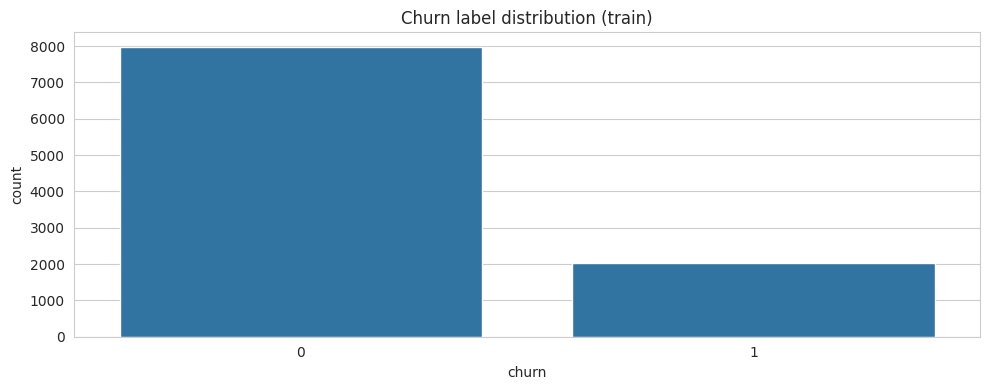

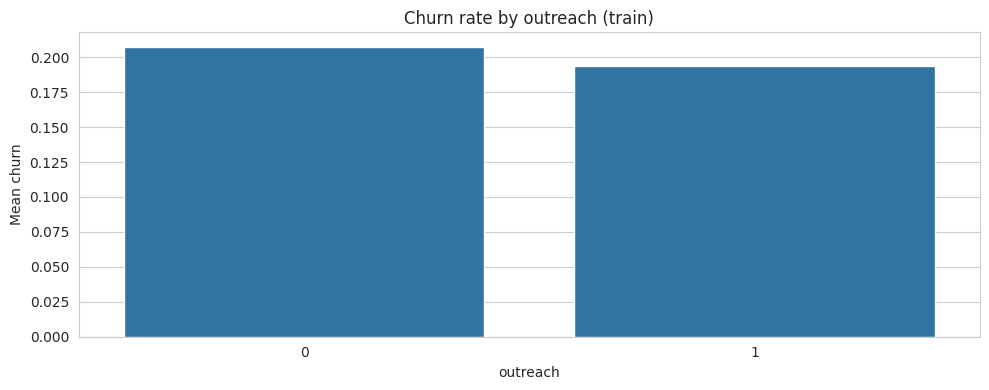

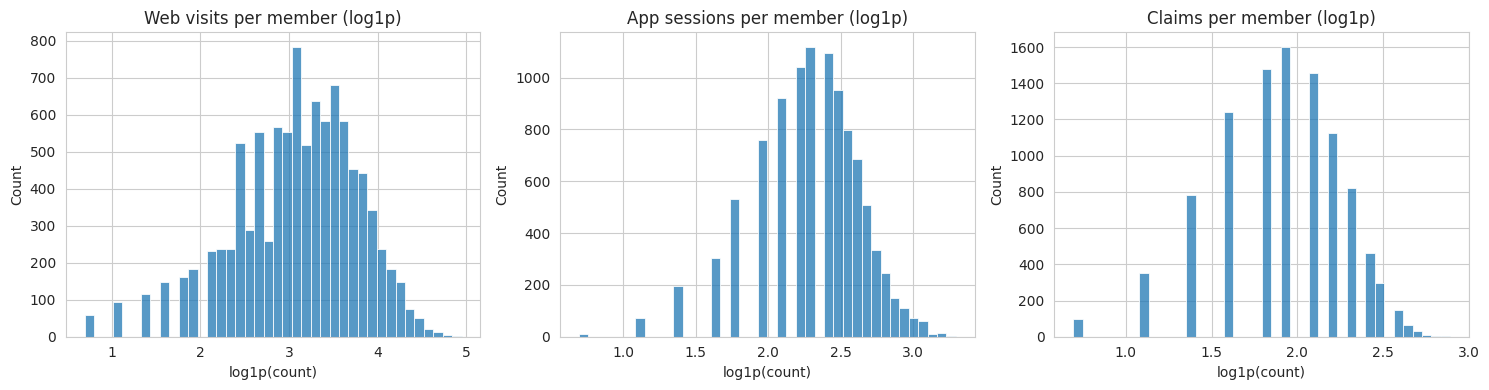

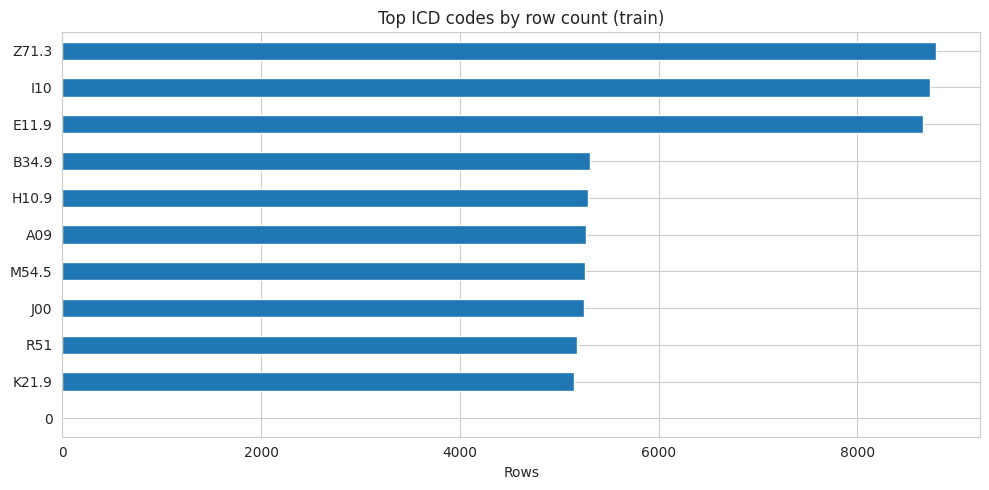

In [5]:

labels_train['signup_date'] = pd.to_datetime(labels_train['signup_date'], errors='coerce')

plt.figure(figsize=(10, 4))
sns.countplot(x='churn', data=labels_train)
plt.title('Churn label distribution (train)')
plt.tight_layout()

plt.figure(figsize=(10, 4))
sns.barplot(x='outreach', y='churn', data=labels_train, errorbar=None)
plt.title('Churn rate by outreach (train)')
plt.ylabel('Mean churn')
plt.tight_layout()

web_train['timestamp'] = pd.to_datetime(web_train['timestamp'], utc=True, errors='coerce')
app_train['timestamp'] = pd.to_datetime(app_train['timestamp'], utc=True, errors='coerce')
claims_train['diagnosis_date'] = pd.to_datetime(claims_train['diagnosis_date'], errors='coerce')

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, df, title in [
    (axes[0], web_train, 'Web visits per member'),
    (axes[1], app_train, 'App sessions per member'),
    (axes[2], claims_train, 'Claims per member'),
]:
    counts = df.groupby('member_id').size()
    sns.histplot(np.log1p(counts), bins=40, ax=ax)
    ax.set_title(title + ' (log1p)')
    ax.set_xlabel('log1p(count)')
plt.tight_layout()


plt.figure(figsize=(10, 5))
claims_train['icd_code'].value_counts().head(15).sort_values().plot(kind='barh')
plt.title('Top ICD codes by row count (train)')
plt.xlabel('Rows')
plt.tight_layout()


## Define observation window

I restrict features to the observation window to avoid using post‑treatment information.


In [6]:
@dataclass(frozen=True)
class ObservationWindow:
    start: pd.Timestamp
    end: pd.Timestamp

    @property
    def n_days(self) -> int:
        return int((self.end.normalize() - self.start.normalize()).days) + 1

def infer_observation_window(*dfs: pd.DataFrame) -> ObservationWindow:
    starts, ends = [], []
    for df in dfs:
        if 'timestamp' in df.columns:
            ts = pd.to_datetime(df['timestamp'], utc=True)
            starts.append(ts.min())
            ends.append(ts.max())
        elif 'diagnosis_date' in df.columns:
            dt = pd.to_datetime(df['diagnosis_date'], utc=True)
            starts.append(dt.min())
            ends.append(dt.max())
    return ObservationWindow(start=min(starts), end=max(ends))

window = infer_observation_window(web_train, app_train, claims_train)
window


ObservationWindow(start=Timestamp('2025-07-01 00:00:00+0000', tz='UTC'), end=Timestamp('2025-07-14 23:59:51+0000', tz='UTC'))

## Data-driven topic discovery for web content

Add words to each topic by looking at the web rows whose title+description contain the seed words 

1) define a small set of seed terms per health topic (seed words taken from 'wellco_client_brief.txt')
2) expand each seed set from the actual web `title + description` text
3) validate topic coverage on train web traffic



In [7]:
CLIENT_BRIEF = (DATA_DIR / 'wellco_client_brief.txt').read_text().strip()
print()

TOPIC_SEEDS = {
    'nutrition': ['nutrition', 'diet', 'healthy eating', 'weight', 'bmi', 'cholesterol'],
    'diabetes': ['diabetes', 'blood sugar', 'glucose', 'hba1c', 'insulin'],
    'hypertension': ['hypertension', 'blood pressure'],
    'movement': ['exercise', 'cardio', 'strength training', 'physical activity'],
    'sleep': ['sleep', 'sleep hygiene', 'sleep apnea'],
    'stress': ['stress', 'mindfulness', 'meditation', 'mental health'],
    'heart_health': ['heart', 'cardiometabolic', 'cardiovascular'],
}


def make_web_text(df: pd.DataFrame) -> pd.Series:
    return (df['title'].fillna('') + ' ' + df['description'].fillna('')).str.lower()


def build_topic_keywords_from_data(
    web_df,
    seeds_by_topic,
    *,
    expand_k = 10,
    sample_n = 80_000,
    min_df = 40,
    max_features = 25_000,
    max_doc_freq = 0.25,
    min_idf = 2.0,
    min_seed_docs = 7000,
    specificity_ratio = 1.4,
    random_state = 42):
    
    text = make_web_text(web_df)
    if len(text) > sample_n:
        text = text.sample(sample_n, random_state=random_state)

    vec = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), min_df=min_df, max_features=max_features)
    X = vec.fit_transform(text)
    vocab = np.array(vec.get_feature_names_out())
    idf = np.array(vec.idf_)
    overall = np.asarray(X.mean(axis=0)).ravel()
    dfreq = np.asarray(X.getnnz(axis=0)).ravel() / X.shape[0]

    topics = list(seeds_by_topic)
    seeds_norm = {t: sorted({s.strip().lower() for s in seeds_by_topic[t] if str(s).strip()}) for t in topics}

    def pat(seeds: list[str]) -> re.Pattern:
        parts = [re.escape(s) if ' ' in s else r'\b' + re.escape(s) + r'\b' for s in seeds]
        return re.compile('(' + '|'.join(parts) + ')', flags=re.IGNORECASE)

    tmean = [
        (lambda m: None if int(m.sum()) < min_seed_docs else np.asarray(X[m].mean(axis=0)).ravel())(
            text.str.contains(pat(seeds_norm[t])).values
        )
        for t in topics]

    score = np.zeros((len(topics), len(vocab)), float)
    for i, tm in enumerate(tmean):
        if tm is not None:
            score[i] = (tm / (overall + 1e-9)) * tm

    best_idx = np.argmax(score, axis=0)
    best = score[best_idx, np.arange(score.shape[1])]
    second = np.partition(score, -2, axis=0)[-2]

    out = {}
    for i, t in enumerate(topics):
        if tmean[i] is None:
            out[t] = seeds_norm[t]
            continue

        seed_set = set(seeds_norm[t])
        tm = tmean[i]
        expanded = []

        for j in np.argsort(-score[i]):
            if len(expanded) >= expand_k:
                break
            term = vocab[j]
            if (
                term in seed_set
                or len(term) < 3
                or dfreq[j] > max_doc_freq
                or idf[j] < min_idf
                or not term.replace(' ', '').isalpha()
                or tm[j] <= 0
                or int(best_idx[j]) != i
                or (best[j] / (second[j] + 1e-9)) < specificity_ratio
            ):
                continue
            expanded.append(term)

        out[t] = sorted(set(seeds_norm[t] + expanded))

    return out


TOPIC_KEYWORDS = build_topic_keywords_from_data(web_train, TOPIC_SEEDS, random_state=RANDOM_STATE)
display(pd.DataFrame({k: pd.Series(v) for k, v in TOPIC_KEYWORDS.items()}))


,nutrition,diabetes,hypertension,movement,sleep,stress,heart_health
0,balanced,blood sugar,blood pressure,cardio,sleep,meditation,cardiometabolic
1,bmi,diabetes,hypertension,cardio strength,sleep apnea,mental health,cardiovascular
2,cholesterol,glucose,NaN,cardio workouts,sleep hygiene,mindfulness,heart
3,diet,hba1c,NaN,exercise,NaN,stress,NaN
4,diet nutrition,insulin,NaN,exercise recovery,NaN,NaN,NaN
5,eating,NaN,NaN,exercise routines,NaN,NaN,NaN
6,health,NaN,NaN,physical activity,NaN,NaN,NaN
7,healthy,NaN,NaN,recovery,NaN,NaN,NaN
8,healthy eating,NaN,NaN,routines,NaN,NaN,NaN
9,management sustainable,NaN,NaN,routines cardio,NaN,NaN,NaN


### Topic coverage check

I validate that the learned keyword sets actually match meaningful portions of the web traffic


In [8]:
web_text_train = make_web_text(web_train)

def compile_keyword_pattern(keywords: list[str]) -> str:
    parts = []
    for kw in keywords:
        kw = kw.lower().strip()
        if not kw:
            continue
        if ' ' in kw:
            parts.append(re.escape(kw))
        else:
            parts.append(r'\b' + re.escape(kw) + r'\b')
    return '(' + '|'.join(parts) + ')'

topic_patterns = {t: re.compile(compile_keyword_pattern(kws), flags=re.IGNORECASE) for t, kws in TOPIC_KEYWORDS.items()}

coverage = {}
for topic, pat in topic_patterns.items():
    m = web_text_train.str.contains(pat)
    coverage[topic] = float(m.mean())

cov = pd.Series(coverage).sort_values(ascending=False)
print('Fraction of web rows matched by topic:')
display(cov.round(2).to_frame('fraction_rows_matched'))
print(f'Percent of matched rows: ', round(100 * cov.sum(),2), '%')



Fraction of web rows matched by topic:


,fraction_rows_matched
nutrition,0.13
movement,0.11
heart_health,0.07
stress,0.07
sleep,0.04
hypertension,0.04
diabetes,0.04


Percent of matched rows:  50.03 %


## Data-driven selection of ICD codes

The client brief highlights E11.9 (type 2 diabetes), I10 (hypertension), Z71.3 (dietary counseling).

I include these explicitly and also add additional ICD codes that are associated with churn in training.


In [9]:
def select_icd_codes(
    claims: pd.DataFrame,
    labels: pd.DataFrame,
    *,
    min_members: int = 150,
    top_k: int = 5,
) -> list[str]:
    dedup = claims[['member_id', 'icd_code']].dropna().drop_duplicates()
    code_counts = dedup['icd_code'].value_counts()
    eligible = code_counts[code_counts >= min_members].index.tolist()

    X_code = pd.crosstab(dedup['member_id'], dedup['icd_code'])
    X_code = (X_code.reindex(columns=eligible, fill_value=0) > 0).astype(int)

    y = labels.set_index('member_id')['churn'].astype(int)
    df = y.to_frame('churn').join(X_code, how='left').fillna(0)

    stats = []
    for code in eligible:
        m = df[code] == 1
        churn_with = float(df.loc[m, 'churn'].mean()) if m.any() else np.nan
        churn_without = float(df.loc[~m, 'churn'].mean()) if (~m).any() else np.nan
        lift = churn_with - churn_without
        stats.append({
            'icd_code': code,
            'members_with_code': int(m.sum()),
            'churn_with_code': churn_with,
            'churn_without_code': churn_without,
            'churn_lift': lift,
            'abs_churn_lift': abs(lift) if np.isfinite(lift) else np.nan,
        })

    stats_df = pd.DataFrame(stats).dropna(subset=['abs_churn_lift'])
    display(stats_df.sort_values('abs_churn_lift', ascending=False).head(20))

    return stats_df.sort_values('abs_churn_lift', ascending=False).head(top_k)['icd_code'].tolist()


SELECTED_ICD_CODES = select_icd_codes(
    claims_train,
    labels_train,
    min_members=150,
    top_k=5,
)

print('Selected ICD codes (train-derived):', SELECTED_ICD_CODES)


,icd_code,members_with_code,churn_with_code,churn_without_code,churn_lift,abs_churn_lift
0,Z71.3,5896,0.188094,0.222222,-0.034129,0.034129
1,I10,5887,0.189061,0.220763,-0.031703,0.031703
2,E11.9,5880,0.194558,0.212864,-0.018306,0.018306
5,M54.5,4154,0.212566,0.194663,0.017903,0.017903
6,A09,4138,0.210488,0.196179,0.014309,0.014309
9,R51,4043,0.207272,0.198590,0.008682,0.008682
7,J00,4108,0.206913,0.198744,0.008169,0.008169
8,K21.9,4062,0.205071,0.200067,0.005004,0.005004
3,B34.9,4202,0.200619,0.203174,-0.002555,0.002555
4,H10.9,4159,0.201250,0.202705,-0.001455,0.001455


Selected ICD codes (train-derived): ['Z71.3', 'I10', 'E11.9', 'M54.5', 'A09']


## Member-level feature engineering

- Aggregate tables web, app, claims to one row per member.
- Filter to the observation window to prevent leakage.

In [10]:
def safe_col(s):
    return re.sub(r'[^0-9a-zA-Z]+', '_', str(s)).strip('_').lower()


def extract_domain(urls):
    dom = urls.fillna('').astype(str).str.extract(r'https?://([^/]+)/', expand=False).fillna('')
    dom = dom.str.lower().str.replace(r'^www\.', '', regex=True)
    return dom


def filter_to_window_ts(df, col, window):
    out = df.copy()
    out[col] = pd.to_datetime(out[col], utc=True)
    return out.loc[(out[col] >= window.start) & (out[col] <= window.end)].copy()


def _daily_counts_wide(df, ts_col, window):
    day0 = window.start.floor('D')
    day_idx = (df[ts_col].dt.floor('D') - day0).dt.days.astype(int)
    g = df.assign(day_idx=day_idx).groupby(['member_id', 'day_idx']).size().unstack(fill_value=0)
    g = g.reindex(columns=range(window.n_days), fill_value=0)
    g.index.name = 'member_id'
    return g


def _trend_slope(counts):
    x = np.arange(counts.shape[1], dtype=float)
    x_c = x - x.mean()
    var_x = (x_c ** 2).sum() + 1e-12
    y = counts.astype(float)
    y_c = y - y.mean(axis=1, keepdims=True)
    return (y_c @ x_c) / var_x


def build_web_features(
    web,
    window,
    topic_keywords,
    top_domains):
    df = filter_to_window_ts(web, 'timestamp', window)
    df['date'] = df['timestamp'].dt.floor('D')

    text = make_web_text(df)
    domain = extract_domain(df['url'])

    patterns = {t: re.compile(compile_keyword_pattern(kws), flags=re.IGNORECASE) for t, kws in topic_keywords.items()}

    out = df.groupby('member_id').agg(
        web_n_visits=('timestamp', 'size'),
        web_n_days=('date', 'nunique'),
        web_n_unique_urls=('url', 'nunique'),
        web_n_unique_titles=('title', 'nunique')).reset_index()

    df_dom = df.assign(domain=domain)
    wellco_mask = df_dom['domain'].str.contains('wellco', case=False, regex=False)
    wellco_counts = df_dom.loc[wellco_mask].groupby('member_id').size()
    out['web_wellco_domain_visits'] = out['member_id'].map(wellco_counts).fillna(0).astype(int)
    out['web_wellco_domain_share'] = out['web_wellco_domain_visits'] / out['web_n_visits'].replace(0, np.nan)

    if top_domains:
        dom_pivot = (
            df_dom.loc[df_dom['domain'].isin(top_domains)]
            .pivot_table(index='member_id', columns='domain', values='url', aggfunc='size', fill_value=0)
            .reset_index()
        )

        rename = {'member_id': 'member_id'}
        for d in top_domains:
            rename[d] = f"web_domain_{safe_col(d)}_cnt"
        dom_pivot = dom_pivot.rename(columns=rename)

        expected_cols = ['member_id'] + [f"web_domain_{safe_col(d)}_cnt" for d in top_domains]
        for c in expected_cols:
            if c not in dom_pivot.columns:
                dom_pivot[c] = 0
        dom_pivot = dom_pivot[expected_cols]

        out = out.merge(dom_pivot, on='member_id', how='left')
        for d in top_domains:
            c = f"web_domain_{safe_col(d)}_cnt"
            out[f"{c}_share"] = out[c] / out['web_n_visits'].replace(0, np.nan)

        share_cols = [f"web_domain_{safe_col(d)}_cnt_share" for d in top_domains]
        out['web_top_domain_share'] = out[share_cols].max(axis=1)

    any_topic_cnt = pd.Series(0, index=df.index, dtype=int)
    for topic, pat in patterns.items():
        mask = text.str.contains(pat)
        any_topic_cnt = any_topic_cnt + mask.astype(int)
        counts = df.loc[mask].groupby('member_id').size()
        out[f'web_topic_{topic}_cnt'] = out['member_id'].map(counts).fillna(0).astype(int)
        out[f'web_topic_{topic}_share'] = out[f'web_topic_{topic}_cnt'] / out['web_n_visits'].replace(0, np.nan)

    any_topic_visits = df.loc[any_topic_cnt > 0].groupby('member_id').size()
    out['web_any_topic_visits'] = out['member_id'].map(any_topic_visits).fillna(0).astype(int)
    out['web_any_topic_share'] = out['web_any_topic_visits'] / out['web_n_visits'].replace(0, np.nan)
    out['web_non_topic_share'] = 1.0 - out['web_any_topic_share']

    daily = _daily_counts_wide(df, 'timestamp', window)
    k = min(3, window.n_days)
    last_cols = list(range(window.n_days - k, window.n_days))

    daily_counts = daily.values

    dyn = pd.DataFrame({
        'member_id': daily.index,
        'web_last3_visits': daily[last_cols].sum(axis=1).values,
        'web_first_day_visits': daily[0].values if window.n_days >= 1 else 0,
        'web_last_day_visits': daily[window.n_days - 1].values if window.n_days >= 1 else 0,
        'web_trend_slope': _trend_slope(daily_counts),
    })

    out = out.merge(dyn, on='member_id', how='left')

    return out.replace([np.inf, -np.inf], np.nan)


def build_app_features(app, window):
    
    df = filter_to_window_ts(app, 'timestamp', window)
    df['date'] = df['timestamp'].dt.floor('D')

    out = df.groupby('member_id').agg(
        app_sessions=('timestamp', 'size'),
        app_active_days=('date', 'nunique')).reset_index()

    out['app_sessions_per_active_day'] = out['app_sessions'] / out['app_active_days'].replace(0, np.nan)
    daily = _daily_counts_wide(df, 'timestamp', window)
    k = min(3, window.n_days)
    last_cols = list(range(window.n_days - k, window.n_days))

    daily_counts = daily.values

    dyn = pd.DataFrame({
        'member_id': daily.index,
        'app_last3_sessions': daily[last_cols].sum(axis=1).values,
        'app_trend_slope': _trend_slope(daily_counts),
    })

    out = out.merge(dyn, on='member_id', how='left')

    return out.replace([np.inf, -np.inf], np.nan)


def build_claims_features(
    claims,
    window,
    selected_codes):
    
    df = filter_to_window_ts(claims, 'diagnosis_date', window)

    out = df.groupby('member_id').agg(
        claims_n=('icd_code', 'size'),
        claims_n_unique_codes=('icd_code', 'nunique'),
        claims_last_dt=('diagnosis_date', 'max'),
    ).reset_index()

    out['claims_recency_days'] = (window.end - out['claims_last_dt']).dt.days.clip(lower=0)
    out.drop(columns=['claims_last_dt'], inplace=True)

    for code in selected_codes:
        cnt = df.loc[df['icd_code'] == code].groupby('member_id').size()
        last = df.loc[df['icd_code'] == code].groupby('member_id')['diagnosis_date'].max()
        safe = code.replace('.', '_')
        out[f'icd_{safe}_cnt'] = out['member_id'].map(cnt).fillna(0).astype(int)
        out[f'icd_{safe}_flag'] = (out[f'icd_{safe}_cnt'] > 0).astype(int)
        rec = (window.end - out['member_id'].map(last)).dt.days
        out[f'icd_{safe}_recency_days'] = rec

    return out


def build_member_frame(labels, web, app, claims, window):
    
    labels = labels.copy()
    labels['signup_date'] = pd.to_datetime(labels['signup_date'], utc=True)

    web_f = build_web_features(web, window, TOPIC_KEYWORDS, TOP_DOMAINS)
    app_f = build_app_features(app, window)
    claims_f = build_claims_features(claims, window, SELECTED_ICD_CODES)

    df = labels.merge(web_f, on='member_id', how='left')
    df = df.merge(app_f, on='member_id', how='left')
    df = df.merge(claims_f, on='member_id', how='left')

    df['tenure_days'] = (window.end.normalize() - df['signup_date'].dt.normalize()).dt.days.clip(lower=0)
    df['tenure_years'] = df['tenure_days'] / 365
    df['tenure_is_new_90d'] = (df['tenure_days'] <= 90).astype(int)
    df['engagement_total_events'] = df['web_n_visits'].fillna(0) + df['app_sessions'].fillna(0)
    df['engagement_total_active_days'] = df['web_n_days'].fillna(0) + df['app_active_days'].fillna(0)
    df['web_visits_per_day'] = df['web_n_visits'] / df['web_n_days'].replace(0, np.nan)
    df['web_unique_titles_per_visit'] = df['web_n_unique_titles'] / df['web_n_visits'].replace(0, np.nan)
    df['web_unique_urls_per_visit'] = df['web_n_unique_urls'] / df['web_n_visits'].replace(0, np.nan)
    df['app_sessions_per_day'] = df['app_sessions'] / df['app_active_days'].replace(0, np.nan)
    df['app_share_of_total_events'] = df['app_sessions'] / df['engagement_total_events'].replace(0, np.nan)
    df['web_visits_per_tenure_year'] = df['web_n_visits'] / (df['tenure_years'] + 1e-6)
    df['app_sessions_per_tenure_year'] = df['app_sessions'] / (df['tenure_years'] + 1e-6)
    df['web_n_visits'] = np.log1p(df['web_n_visits'])
    df['app_sessions'] = np.log1p(df['app_sessions'])
    df['claims_n'] = np.log1p(df['claims_n'])
    df['web_any_topic_visits'] = np.log1p(df.get('web_any_topic_visits', 0))
    df['web_wellco_domain_visits'] = np.log1p(df.get('web_wellco_domain_visits', 0))
    df['tenure_x_app_sessions'] = df['tenure_years'] * df['app_sessions'].fillna(0)

    recency_cols = [c for c in df.columns if c.endswith('recency_days')]
    df[recency_cols] = df[recency_cols].fillna(window.n_days + 1)

    numeric_cols = df.select_dtypes(include=['number']).columns
    df[numeric_cols] = df[numeric_cols].fillna(0)
    df = df.replace([np.inf, -np.inf], 0)
    df = df.drop(columns=['tenure_years'], errors='ignore')
    
    return df


web_train_in = filter_to_window_ts(web_train, 'timestamp', window)
_dom = extract_domain(web_train_in['url'])
TOP_DOMAINS = _dom.value_counts().head(20).index.tolist()
train_df = build_member_frame(labels_train, web_train, app_train, claims_train, window)
test_df = build_member_frame(labels_test, web_test, app_test, claims_test, window)
BASE_FEATURE_COLS = [c for c in train_df.columns if c not in ['member_id', 'churn', 'outreach', 'signup_date']]
missing_in_test = [c for c in BASE_FEATURE_COLS if c not in test_df.columns]

for c in missing_in_test:
    test_df[c] = 0
extra_in_test = [c for c in test_df.columns if c in BASE_FEATURE_COLS and c not in train_df.columns]

X_train = train_df[BASE_FEATURE_COLS]
y_train = train_df['churn'].astype(int)
t_train = train_df['outreach'].astype(int)

X_test = test_df[BASE_FEATURE_COLS]
y_test = test_df['churn'].astype(int)
t_test = test_df['outreach'].astype(int)

print('Base features:', len(BASE_FEATURE_COLS))


Base features: 79


### Features summary
I built member-level features from the three behavioral sources available in the observation window (web visits, app usage, and claims) plus tenure, because these reflect engagement, health interests, and health burden — three plausible drivers of churn.

**Tenure / lifecycle**: tenure_days (and simple transforms) capture how established a member is; new members often behave differently from long-tenured members, and tenure also stabilizes per-day rates (domain relevance, high data quality).


**Web engagement + content interest**: counts/recency/active-days summarize how much the member interacts with WellCo content; topic shares (nutrition/diabetes/etc.) and domain patterns add interpretable signals about health intent and needs (domain relevance, predictive in importance/coefficients, moderate noise controlled via filtering/keyword expansion).


**App engagement**: sessions, active days, recency, and weekday/weekend usage proxy habit formation and product value; low/declining usage is often a churn precursor (domain relevance, high data quality).

**Claims / clinical burden**: claim counts, recency, and selected ICD indicators summarize underlying health conditions and care utilization that can affect both churn risk and responsiveness to outreach           


## Baseline metrics (provided - on the full test set)


In [11]:
baseline_auc = (DATA_DIR / 'auc_baseline_test.txt').read_text().strip()
baseline_report = (DATA_DIR / 'classification_report_baseline_test.txt').read_text().strip()
print('Given Baseline:')
print(baseline_auc)
print()
print('Baseline classification report:')
print(baseline_report)


Given Baseline:
ROC-AUC_random_test=0.489076

Baseline classification report:
precision    recall  f1-score   support

    no_churn       0.80      0.51      0.62      7996
       churn       0.20      0.48      0.28      2004

    accuracy                           0.50     10000
   macro avg       0.50      0.49      0.45     10000
weighted avg       0.68      0.50      0.55     10000


## Model 1: churn-risk model

### Model Benchmarking (Train CV)

#### I compare different models results: 
- `LogReg`
- `RandomForest` 
- `xgboost` 

Then, after I choose model, I compare test evaluation to the provided baseline.


,model,cv_mean_auc,cv_std_auc
0,LogReg,0.668347,0.018460
1,RandomForest,0.660748,0.017564
2,XGBoost,0.638412,0.010997


Selected model: LogReg
Test ROC AUC: 0.6682

Classification report (test, threshold=0.5):
              precision    recall  f1-score   support

    no_churn       0.86      0.64      0.74      7996
       churn       0.30      0.59      0.39      2004

    accuracy                           0.63     10000
   macro avg       0.58      0.62      0.57     10000
weighted avg       0.75      0.63      0.67     10000



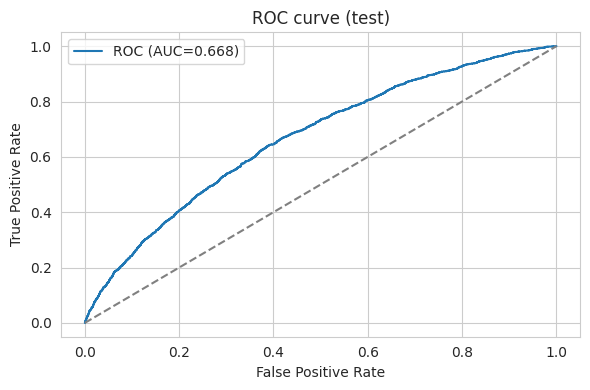

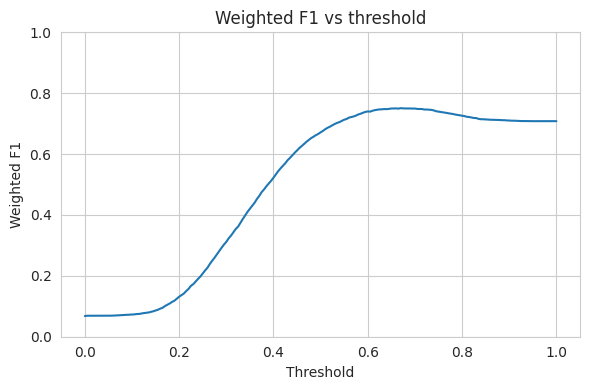

In [12]:
def make_lr() -> Pipeline:
    return Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(max_iter=4000, solver='lbfgs', class_weight='balanced')),
    ])


def make_rf(seed: int) -> RandomForestClassifier:
    return RandomForestClassifier(
        n_estimators=500,
        min_samples_leaf=5,
        max_features='sqrt',
        n_jobs=-1,
        random_state=seed,
    )


def make_xgb(seed: int):

    return xgb.XGBClassifier(
        n_estimators=800,
        learning_rate=0.04,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        min_child_weight=5,
        objective='binary:logistic',
        eval_metric='auc',
        tree_method='hist',
        random_state=seed,
        n_jobs=-1,
        verbosity=0,
    )


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

models = {
    'LogReg': lambda seed: make_lr(),
    'RandomForest': lambda seed: make_rf(seed),
    'XGBoost': lambda seed: make_xgb(seed)}


rows = []
oof_by_model = {}

for name, factory in models.items():
    oof = np.zeros(len(X_train))
    fold_aucs = []

    for fold, (tr, va) in enumerate(skf.split(X_train, y_train)):
        m = factory(RANDOM_STATE + fold)
        m.fit(X_train.iloc[tr], y_train.iloc[tr])
        p = m.predict_proba(X_train.iloc[va])[:, 1]
        oof[va] = p
        fold_aucs.append(roc_auc_score(y_train.iloc[va], p))

    oof_by_model[name] = oof
    rows.append({'model': name, 'cv_mean_auc': float(np.mean(fold_aucs)), 'cv_std_auc': float(np.std(fold_aucs))})

cv_table = pd.DataFrame(rows).sort_values('cv_mean_auc', ascending=False).reset_index(drop=True)
display(cv_table)

best_name = str(cv_table.iloc[0]['model'])
print('Selected model:', best_name)

churn_risk_model = models[best_name](RANDOM_STATE)
churn_risk_model.fit(X_train, y_train)

thresholds = np.linspace(0, 1, 201)
best_oof = oof_by_model[best_name]
weighted_f1 = np.array([f1_score(y_train, (best_oof >= t).astype(int), average='weighted') for t in thresholds])

# Evaluate on TEST
p_test_risk = churn_risk_model.predict_proba(X_test)[:, 1]
auc_test = roc_auc_score(y_test, p_test_risk)
print('Test ROC AUC:', round(float(auc_test), 4))

thr = 0.5
print() 
print(f'Classification report (test, threshold={thr}):')
print(classification_report(y_test, (p_test_risk >= thr).astype(int), target_names=['no_churn','churn']))

fpr, tpr, _ = roc_curve(y_test, p_test_risk)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC (AUC={float(auc_test):.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC curve (test)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.tight_layout()

plt.figure(figsize=(6, 4))
plt.plot(thresholds, weighted_f1)
plt.title('Weighted F1 vs threshold')
plt.xlabel('Threshold')
plt.ylabel('Weighted F1')
plt.ylim(0, 1)
plt.tight_layout()


### Model Evaluation
**Primary metric**: ROC-AUC on stratified K-fold CV (train). ROC-AUC is threshold-independent and measures ranking quality, which is important under class imbalance (~20% churn).

Secondary diagnostics: classification report / confusion matrix at a fixed threshold 

## Feature importance (Model 1: churn-risk)

- **Coefficient magnitude** 


,feature,coef,abs_coef
69,engagement_total_events,-1.150644,1.150644
0,web_n_visits,1.132273,1.132273
67,tenure_days,-0.654269,0.654269
37,web_any_topic_visits,-0.547426,0.547426
71,web_visits_per_day,-0.513406,0.513406
2,web_n_unique_urls,0.463978,0.463978
78,tenure_x_app_sessions,0.423574,0.423574
8,web_domain_world_news_cnt,0.315656,0.315656
6,web_domain_portal_site_cnt,0.290299,0.290299
9,web_domain_media_hub_cnt,0.289920,0.289920


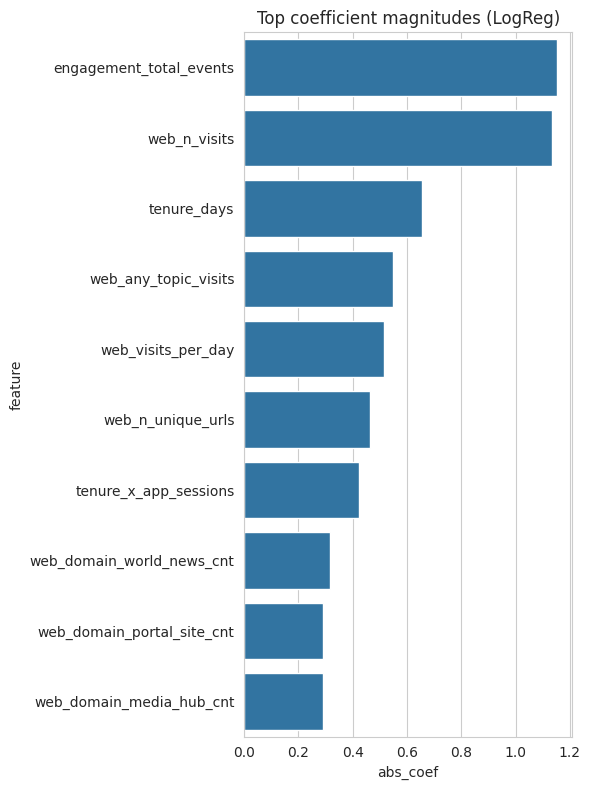

In [13]:
if hasattr(churn_risk_model, 'named_steps') and 'model' in churn_risk_model.named_steps:
    lr = churn_risk_model.named_steps['model']
    if hasattr(lr, 'coef_'):
        coef = lr.coef_.ravel()
        coef_imp = (
            pd.DataFrame({'feature': X_train.columns, 'coef': coef, 'abs_coef': np.abs(coef)})
            .sort_values('abs_coef', ascending=False)
        )
        display(coef_imp.head(10))

        plt.figure(figsize=(6, 8))
        sns.barplot(data=coef_imp.head(10), y='feature', x='abs_coef')
        plt.title('Top coefficient magnitudes (LogReg)')
        plt.tight_layout()

## Model 2: uplift modeling (who benefits from outreach)
##### Fits a propensity model P(outreach|X) - estimate of how likely a member was to receive outreach, given their features X.

Outreach happens after the observation window but before churn is measured, so it can change the churn outcome.                            
 I therefore treat outreach as a treatment and use uplift modeling:
estimate P(outreach|X) to adjust for non-random outreach, 

predict churn under no-outreach vs outreach, 
and rank members by uplift = P(churn|no outreach) − P(churn|outreach) (expected churn reduction).

Model uplift score is:  **P(churn | no outreach) -  P(churn | outreach)**


In [14]:
def fit_uplift_models(
    X: pd.DataFrame,
    y: pd.Series,
    t: pd.Series,
    random_state: int):
    
    propensity = Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=500, solver='lbfgs')),
    ])
    propensity.fit(X, t)
    ps = np.clip(propensity.predict_proba(X)[:, 1], 1e-3, 1 - 1e-3)
    w = np.where(t.values == 1, 1.0 / ps, 1.0 / (1.0 - ps))

    model_c = HistGradientBoostingClassifier(
        learning_rate=0.05,
        max_depth=3,
        max_iter=400,
        l2_regularization=0.1,
        random_state=random_state,
    )
    model_t = HistGradientBoostingClassifier(
        learning_rate=0.05,
        max_depth=3,
        max_iter=400,
        l2_regularization=0.1,
        random_state=random_state + 1,
    )

    m0 = (t.values == 0)
    m1 = (t.values == 1)
    model_c.fit(X.loc[m0], y.loc[m0], sample_weight=w[m0])
    model_t.fit(X.loc[m1], y.loc[m1], sample_weight=w[m1])
    return propensity, model_c, model_t

def predict_uplift(model_c, model_t, X: pd.DataFrame) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    p0 = model_c.predict_proba(X)[:, 1]
    p1 = model_t.predict_proba(X)[:, 1]
    return p0, p1, (p0 - p1)


stratify_key = (y_train.astype(str) + '_' + t_train.astype(str))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
oof_p0 = np.zeros(len(train_df))
oof_p1 = np.zeros(len(train_df))
oof_uplift = np.zeros(len(train_df))

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train, stratify_key)):
    X_tr, y_tr, t_tr = X_train.iloc[tr_idx], y_train.iloc[tr_idx], t_train.iloc[tr_idx]
    X_va = X_train.iloc[va_idx]

    _, mc, mt = fit_uplift_models(X_tr, y_tr, t_tr, random_state=RANDOM_STATE + 10 * fold)
    p0, p1, u = predict_uplift(mc, mt, X_va)
    oof_p0[va_idx], oof_p1[va_idx], oof_uplift[va_idx] = p0, p1, u

train_uplift = pd.DataFrame({
    'member_id': train_df['member_id'].values,
    'uplift': oof_uplift,
    'p_churn_no_outreach': oof_p0,
    'p_churn_with_outreach': oof_p1,
    'churn': y_train.values,
    'outreach': t_train.values,
})

print("Top uplift members: ")
train_uplift.sort_values('uplift', ascending=False).head(10)


Top uplift members: 


,member_id,uplift,p_churn_no_outreach,p_churn_with_outreach,churn,outreach
7959,7960,0.601056,0.633889,0.032833,0,0
3873,3874,0.594302,0.724907,0.130605,0,1
5418,5419,0.566156,0.576521,0.010366,0,0
3775,3776,0.559075,0.676580,0.117504,0,1
1374,1375,0.556617,0.710137,0.153520,0,1
5521,5522,0.553223,0.686361,0.133139,0,1
922,923,0.534407,0.735056,0.200649,0,1
8237,8238,0.522119,0.601960,0.079841,1,0
4923,4924,0.520930,0.588199,0.067270,0,0
5646,5647,0.513075,0.706218,0.193143,0,1


## Choose outreach size n
I choose the "n" by defining a threshold for slope of cummulative expected churn - as can be seen in the graph

Members with positive uplift: 6845
Recommended n by rolling slope heuristic: 5846


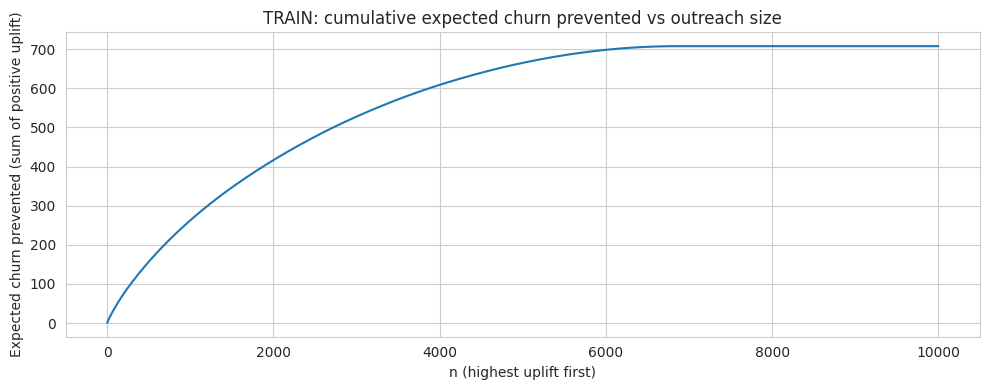

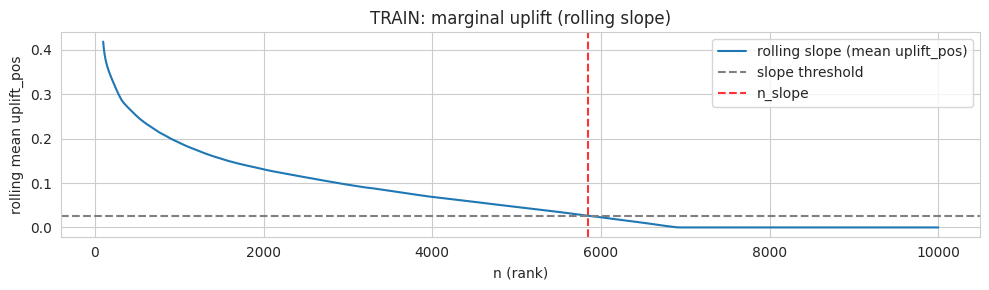

In [15]:
train_rank = (
    train_uplift
    .sort_values(['uplift', 'p_churn_no_outreach'], ascending=[False, False])
    .reset_index(drop=True))

train_rank['rank'] = np.arange(1, len(train_rank) + 1)
train_rank['uplift_pos'] = train_rank['uplift'].clip(lower=0)
train_rank['cum_expected_churn_prevented'] = train_rank['uplift_pos'].cumsum()

plt.figure(figsize=(10, 4))
plt.plot(train_rank['rank'], train_rank['cum_expected_churn_prevented'])
plt.title('TRAIN: cumulative expected churn prevented vs outreach size')
plt.xlabel('n (highest uplift first)')
plt.ylabel('Expected churn prevented (sum of positive uplift)')
plt.tight_layout()

n_positive = int((train_rank['uplift'] > 0).sum())
print('Members with positive uplift:', n_positive)

window = 100        
ref_window = 1000    
slope_frac_stop = 0.10  

marginal = train_rank['uplift_pos'].values
ref = float(np.mean(marginal[: min(ref_window, len(marginal))]))
slope_threshold = slope_frac_stop * ref

roll_slope = pd.Series(marginal).rolling(window, min_periods=window).mean().values
idxs = np.where(roll_slope <= slope_threshold)[0]
n_slope = int(idxs[0] + 1) if len(idxs) else n_positive

plt.figure(figsize=(10, 3))
plt.plot(roll_slope, label='rolling slope (mean uplift_pos)')
plt.axhline(slope_threshold, color='gray', linestyle='--', label='slope threshold')
plt.axvline(n_slope, color='red', linestyle='--', alpha=0.8, label='n_slope')
plt.title('TRAIN: marginal uplift (rolling slope)')
plt.xlabel('n (rank)')
plt.ylabel('rolling mean uplift_pos')
plt.legend(loc='best')
plt.tight_layout()


print('Recommended n by rolling slope heuristic:', n_slope)


## Fit final uplift models on full TRAIN, score TEST, export
Take the final uplift models trained on all TRAIN data and use them to score TEST members, then export the top‑n outreach list

TEST observed-treatment ROC AUC: 0.6512
Prioritized members: /home/ubuntu/work/yuval/vi/output/outreach_prioritized_members.csv


,member_id,prioritization_score,rank,p_churn_no_outreach,p_churn_with_outreach
0,2395,0.626701,1,0.789773,0.163071
1,8069,0.618573,2,0.824166,0.205593
2,5329,0.576287,3,0.661647,0.085360
3,8002,0.564168,4,0.719551,0.155383
4,3919,0.559790,5,0.610326,0.050536
5,3641,0.557089,6,0.587194,0.030105
6,6762,0.553056,7,0.591830,0.038775
7,8256,0.549817,8,0.564278,0.014460
8,6704,0.542641,9,0.639722,0.097081
9,466,0.538363,10,0.814280,0.275918


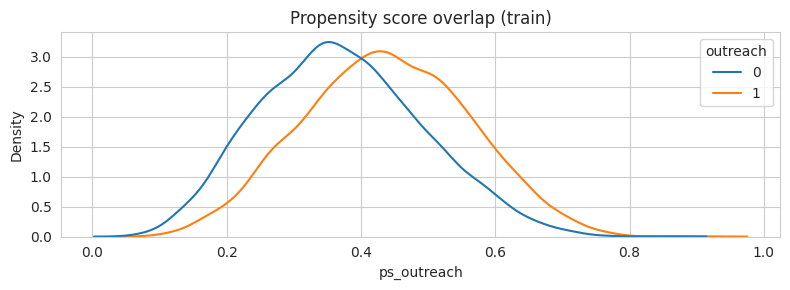

In [16]:
propensity_full, model_c_full, model_t_full = fit_uplift_models(X_train, y_train, t_train, random_state=RANDOM_STATE)
p0_test, p1_test, uplift_test = predict_uplift(model_c_full, model_t_full, X_test)

p_obs_test = np.where(t_test.values == 1, p1_test, p0_test)
print('TEST observed-treatment ROC AUC:', roc_auc_score(y_test, p_obs_test).round(4))

# Propensity overlap
ps_train = np.clip(propensity_full.predict_proba(X_train)[:, 1], 1e-3, 1-1e-3)
df_ps = pd.DataFrame({'ps_outreach': ps_train, 'outreach': t_train.values})
plt.figure(figsize=(8, 3))
sns.kdeplot(data=df_ps, x='ps_outreach', hue='outreach', common_norm=False)
plt.title('Propensity score overlap (train)')
plt.tight_layout()

# Export prioritized list
ranking = pd.DataFrame({
    'member_id': test_df['member_id'].values,
    'p_churn_no_outreach': p0_test,
    'p_churn_with_outreach': p1_test,
    'uplift': uplift_test,
})
ranking = ranking.sort_values(['uplift','p_churn_no_outreach'], ascending=[False, False]).reset_index(drop=True)
ranking['rank'] = np.arange(1, len(ranking) + 1)

OUT_PATH = OUTPUT_DIR / 'outreach_prioritized_members.csv'
out = ranking.head(n_slope).copy()
out = out[['member_id','uplift','rank','p_churn_no_outreach','p_churn_with_outreach']]
out = out.rename(columns={'uplift': 'prioritization_score'})
out.to_csv(OUT_PATH, index=False, )
print('Prioritized members:', OUT_PATH.resolve())
display(out.head(10))


This plot shows the model-estimated propensity score `P(outreach=1 | X)`, split by whether member actually received outreach (`outreach=1`) or not (`outreach=0`)


#### The next graph shows uplift ranking vs random outreach
Evaluation: a cumulative “expected churn prevented vs n” curve compared to a random baseline. this directly reflects the value of targeting.

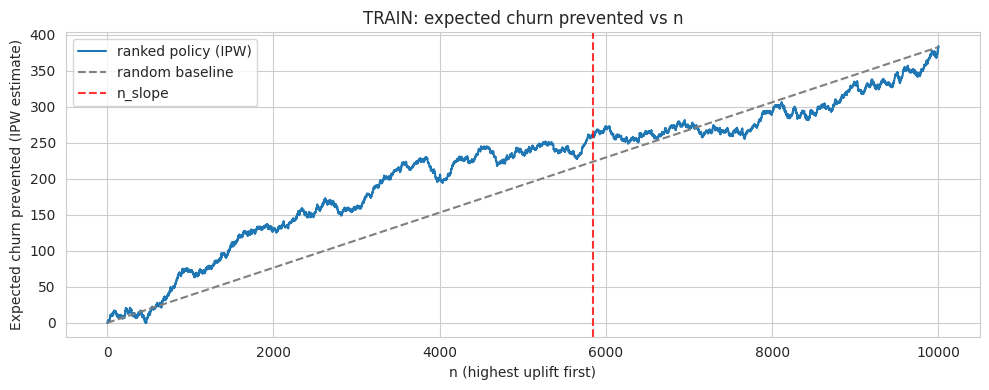

In [17]:
if "train_uplift" not in globals():
    raise ValueError("train_uplift not found; run the OOF uplift cell first.")

if "ps_train" in globals():
    ps = np.clip(np.asarray(ps_train).ravel(), 1e-3, 1 - 1e-3)
elif "propensity_full" in globals():
    ps = np.clip(propensity_full.predict_proba(X_train)[:, 1], 1e-3, 1 - 1e-3)
else:
    propensity_tmp = Pipeline([("scaler", StandardScaler()), ("lr", LogisticRegression(max_iter=500, solver="lbfgs"))])
    propensity_tmp.fit(X_train, t_train)
    ps = np.clip(propensity_tmp.predict_proba(X_train)[:, 1], 1e-3, 1 - 1e-3)

df_eval = train_uplift.copy()
df_eval["ps"] = ps
df_eval = df_eval.sort_values(["uplift", "p_churn_no_outreach"], ascending=[False, False]).reset_index(drop=True)

t = df_eval["outreach"].values.astype(float)
y = df_eval["churn"].values.astype(float)
ps = df_eval["ps"].values.astype(float)
w1 = t / ps
w0 = (1.0 - t) / (1.0 - ps)

cum_w1 = np.cumsum(w1)
cum_w0 = np.cumsum(w0)
cum_yw1 = np.cumsum(w1 * y)
cum_yw0 = np.cumsum(w0 * y)

mu1 = cum_yw1 / (cum_w1 + 1e-12)
mu0 = cum_yw0 / (cum_w0 + 1e-12)
ate_prefix = mu0 - mu1  

n = np.arange(1, len(df_eval) + 1)
prevented_prefix = ate_prefix * n
prevented_all = float(prevented_prefix[-1])
prevented_random = prevented_all * (n / n[-1])


plt.figure(figsize=(10, 4))
plt.plot(n, prevented_prefix, label="ranked policy (IPW)")
plt.plot(n, prevented_random, linestyle="--", color="gray", label="random baseline")
plt.title("TRAIN: expected churn prevented vs n")
plt.axvline(n_slope, color="red", linestyle="--", alpha=0.8, label="n_slope")
plt.xlabel("n (highest uplift first)")
plt.ylabel("Expected churn prevented (IPW estimate)")
plt.legend(loc="best")
plt.tight_layout()


The End, thank you for your time